In [1]:
#!pip3 install -e .
import numpy as np
import matplotlib.pyplot as plt
from astropy import convolution
from astropy.io import fits
from scipy import signal
import emcee
from multiprocessing import Pool, get_context
from fit_ring import fit_ring

In [13]:
Band = "Band4"
#Band = "Band6"
ring = "inner"
#ring = "outer"
limit_theta = True
#limit_theta = False
n_walker = 16

In [14]:
if Band == "Band6":
    hdulist = fits.open("../obs/hd163296_band6.fits")
    wavelength = 0.1254450233571054
    NCUT = 1000
    sigma = 0.18263960681950794 # noise level in Band 6 after smoothing. Before smoothing, noise level is 0.2585670770753724 K
    smooth_B6_image = True
    if ring == "inner":
        pos = np.array([0.9, 1.2, 68.0, 0.7, 4.7, 4.1])+  np.array([0.5, 0.5, 0.5, 0.1, 0.5, 0.5])* np.random.randn(n_walker, 6)
    elif ring == "outer":
        pos = np.array([0.9, 1.2, 68.0, 0.7, 4.7, 4.1])+  0.1* np.random.randn(n_walker, 6)
    else:
        raise ValueError("ring must be either inner or outer")
elif Band == "Band4":
    NCUT = 200
    hdulist = fits.open("../obs/hd163296_band4.fits")
    wavelength = 0.21416788052496163
    sigma = 0.1925369232259328
    smooth_B6_image = False
    if ring == "inner":
        pos = np.array([0.9, 1.2, 68.0, 0.4, 4.7, 4.1])+  np.array([0.5, 0.5, 0.5, 0.1, 0.5, 0.5])* np.random.randn(n_walker, 6)
    elif ring == "outer":
        pos = np.array([0.9, 1.1, 68.0, 0.7, 4.7, 4.1])+  0.1* np.random.randn(n_walker, 6)
    else:
        raise ValueError("ring must be either inner or outer")   
else:
    raise ValueError("Band must be either Band4 or Band6")


if ring == "inner":
    r_range = [60.0, 75.0]
elif ring == "outer":
    r_range = [94.0, 106.0]


temperature_t0 = 21.8
temperature_r0 = 100.0
temperature_pow = -0.5

# smooth B6 image to be the same beam size as B4
BMAJ_B6toB4 = 5.024359709644313
BMIN_B6toB4 = 3.4857659914758288 
BPA_B6toB4 = 144.70473062543104 #2.525573992625245/np.pi*180

BMAJ_B4 = 6.5696999281654325 
BMIN_B4 = 5.704718712715835 
BPA_B4 = -54.94570922852

In [15]:
# distance
dis = 101.0 # pc
# disk geomertry
incl = 46.7/180*np.pi # inclination in degree
posang = 133.3/180*np.pi # position angle in degree
posang_proj = posang + np.pi/2

# read fits data
pic = hdulist[0]
header = pic.header
image = pic.data[0,0]
image = image[NCUT:-NCUT,NCUT:-NCUT]

# check pixcel of figure
NAXIS1 = header['NAXIS1'] - NCUT*2
NAXIS2 = header['NAXIS2'] - NCUT*2
# check range (sec) per pixcel
CDELT1 = header['CDELT1']*3600
CDELT2 = header['CDELT2']*3600
CDELT1 = abs(CDELT1)
CDELT2 = abs(CDELT2)
BMAJ = header['BMAJ']*3600
BMIN = header['BMIN']*3600
BPA = header['BPA']

# Band 6 frequency: 233.0 GHz
freqGHz = 29.9792458/wavelength
image = 1.222e6 * image/BMAJ/BMIN/freqGHz**2

noise_level = 1.234870664277e-5*1.222e6/BMAJ/BMIN/freqGHz**2
CDELT1 = CDELT1 * dis
CDELT2 = CDELT2 * dis
BMAJ = BMAJ * dis
BMIN = BMIN * dis

# smooth B6 image
if smooth_B6_image:
    beam_kernel = convolution.Gaussian2DKernel(BMIN_B6toB4/2.355/CDELT2, BMAJ_B6toB4/2.355/CDELT1, theta=(BPA_B6toB4/180*np.pi)).array
    #image = convolution.convolve_fft(image, beam_kernel)
    image = signal.fftconvolve(image, beam_kernel, mode="same") # fastest
    print("smoothed the image")
else:
    print("the image is not smoothed")

the image is not smoothed


In [16]:
import scipy.interpolate as interpolate
# convert to radian
def deproject_image(image, ratio, pa_rad, nx0, ny0):
    nx, ny = image.shape
    # create coordinate system
    x = np.arange(nx)
    y = np.arange(ny)
    xx, yy = np.meshgrid(x, y, indexing="xy")
    # deproject
    dxx1 =  (xx-nx0)*np.cos(pa_rad) + (yy-ny0)*np.sin(pa_rad)
    dyy1 = -(xx-nx0)*np.sin(pa_rad) + (yy-ny0)*np.cos(pa_rad)
    dyy1 = dyy1 / ratio
    xx2 =  dxx1*np.cos(pa_rad) - dyy1*np.sin(pa_rad) + nx0
    yy2 = +dxx1*np.sin(pa_rad) + dyy1*np.cos(pa_rad) + ny0

    # interpolate image
    f = interpolate.RectBivariateSpline(np.arange(nx), np.arange(ny), image.T)
    image_deprojected = f.ev(xx2, yy2)
    return image_deprojected

def deproject_grid(xx, yy, ratio, pa_rad, x0=0, y0=0):
    # deproject
    dxx1 =  (xx-x0)*np.cos(pa_rad) + (yy-y0)*np.sin(pa_rad)
    dyy1 = -(xx-x0)*np.sin(pa_rad) + (yy-y0)*np.cos(pa_rad)
    dyy1 = dyy1 * ratio
    xx2 =  dxx1*np.cos(pa_rad) - dyy1*np.sin(pa_rad) + x0
    yy2 = +dxx1*np.sin(pa_rad) + dyy1*np.cos(pa_rad) + y0
    return xx2, yy2

# deproject all images
image_deproj = deproject_image(image, 1/np.cos(incl), posang_proj, (NAXIS1-1)/2, (NAXIS2-1)/2)

In [17]:
# make grid for observational ana
x_obs = np.linspace(-(NAXIS1-1)*CDELT1/2, (NAXIS1-1)*CDELT1/2, NAXIS1)
y_obs = np.linspace(-(NAXIS2-1)*CDELT2/2, (NAXIS2-1)*CDELT2/2, NAXIS2)
xx_obs, yy_obs = np.meshgrid(x_obs, y_obs, indexing='xy')

BMAJ_indep = BMAJ_B4
BMIN_indep = BMIN_B4
BAVE_indep = np.sqrt(BMAJ_indep*BMIN_indep)

n_grid_half = int(r_range[1]/BAVE_indep) + 1
x_data_point = np.arange(-n_grid_half, n_grid_half+1) * BAVE_indep
y_data_point = np.arange(-n_grid_half, n_grid_half+1) * BAVE_indep
xx_data_point, yy_data_point = np.meshgrid(x_data_point, y_data_point, indexing='xy')
xx_data_point = xx_data_point.flatten()
yy_data_point = yy_data_point.flatten()

# deproject grid
xx_data_point_deproj, yy_data_point_deproj = deproject_grid(xx_data_point, yy_data_point, 1/np.cos(incl), posang_proj)
rr_data_point = np.sqrt(xx_data_point_deproj**2 + yy_data_point_deproj**2)
theta_data_point = np.arctan2(yy_data_point_deproj, xx_data_point_deproj)

# choose data points to fit
xx_data_point, yy_data_point = xx_data_point[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])], yy_data_point[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])]
xx_data_point_deproj, yy_data_point_deproj = xx_data_point_deproj[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])], yy_data_point_deproj[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])]
if (limit_theta):
    xx_data_point, yy_data_point = xx_data_point[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)], yy_data_point[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)]
    xx_data_point_deproj, yy_data_point_deproj = xx_data_point_deproj[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)], yy_data_point_deproj[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)]

In [18]:
x_obs.shape

(624,)

In [19]:
x_model = np.linspace(-119.5, 119.5, 240)
y_model = np.linspace(-119.5, 119.5, 240)
xx_model, yy_model  = np.meshgrid(x_model, y_model, indexing="xy")

# deproject grid
xx_model_incl, yy_model_incl = deproject_grid(xx_model, yy_model, 1/np.cos(incl), posang_proj)

bmaj_model = BMAJ_B4
bmin_model = BMIN_B4
bpa_model = BPA_B4
dx = x_model[1] - x_model[0]
dy = y_model[1] - y_model[0]
bmaj_model_n = bmaj_model / dx
bmin_model_n = bmin_model / dx

beam_kernel = convolution.Gaussian2DKernel(bmin_model_n/2.355, bmaj_model/2.355, bpa_model/180*np.pi).array



In [20]:
def log_likelihood(params, sigma):
    xcen, ycen, ring_r0, ring_tau, ring_w, ring_h = params
    xx_data_point_cen = xx_data_point + xcen
    yy_data_point_cen = yy_data_point + ycen
    obs_data_points = fit_ring.interpolate_data(x_obs, y_obs, image.T, xx_data_point_cen, yy_data_point_cen)
    intensity = fit_ring.raytrace_ring(ring_r0, ring_tau, ring_w, ring_h, incl, posang, temperature_t0, temperature_r0, temperature_pow, wavelength, xx_model_incl, yy_model_incl)
    #intensity_conv = fit_ring.convolution(intensity, beam_kernel)
    intensity_conv = signal.fftconvolve(intensity, beam_kernel, mode="same")
    model_data_points = fit_ring.interpolate_data(x_model, y_model, intensity_conv.T, xx_data_point, yy_data_point)
    chi2 = np.sum((obs_data_points - model_data_points)**2)/sigma**2
    return -0.5 * chi2

def log_prior(params):
    xcen, ycen, ring_r0, ring_tau, ring_w, ring_h = params
    if -2.0<xcen<2.0 and -2.0< ycen<2.0 and 65.0<ring_r0<70.0 and 0.0<ring_tau<2.0 and 0.0<ring_w<6.0 and 0.0<ring_h<6.0:
        return 0.0
    return -np.inf

def log_probability(params, sigma):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, sigma)

nwalkers, ndim = pos.shape

num_cores=8
#with Pool(num_cores) as pool: # for Intel CPU
with get_context("fork").Pool(num_cores) as pool: # for M1 Mac
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=([sigma]), pool=pool)
    sampler.run_mcmc(pos, 10, progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/doikiyoaki/Library/Python/3.8/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


In [21]:
flat_samples = sampler.get_chain(discard=500, thin=1, flat=True)
print(flat_samples.shape)

import corner

labels = ["xcen", "ycen", "ring_r0", "ring_tau", "ring_w", "ring_h"]
fig = corner.corner(
    flat_samples, labels=labels
)

from IPython.display import display, Math

labels = ["xcen", "ycen", "ring_r0", "ring_tau", "ring_w", "ring_h"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

(0, 6)


AssertionError: I don't believe that you want more dimensions than samples!

In [22]:
def log_likelihood(params, sigma):
    xcen, ycen, ring_r0, ring_tau, ring_w, ring_h = params
    xx_data_point_cen = xx_data_point + xcen
    yy_data_point_cen = yy_data_point + ycen
    obs_data_points = fit_ring.interpolate_data(x_obs, y_obs, image.T, xx_data_point_cen, yy_data_point_cen)
    intensity = fit_ring.raytrace_ring(ring_r0, ring_tau, ring_w, ring_h, incl, posang, temperature_t0, temperature_r0, temperature_pow, wavelength, xx_model_incl, yy_model_incl)
    #intensity_conv = fit_ring.convolution(intensity, beam_kernel)
    intensity_conv = signal.fftconvolve(intensity, beam_kernel, mode="same")
    model_data_points = fit_ring.interpolate_data(x_model, y_model, intensity_conv.T, xx_data_point, yy_data_point)
    chi2 = np.sum((obs_data_points - model_data_points)**2)/sigma**2
    return -0.5 * chi2

def log_prior(params):
    xcen, ycen, ring_r0, ring_tau, ring_w, ring_h = params
    if -2.0<xcen<2.0 and -2.0< ycen<2.0 and 65.0<ring_r0<70.0 and 0.0<ring_tau<2.0 and 0.0<ring_w<6.0 and 0.0<ring_h<6.0:
        return 0.0
    return -np.inf

def log_probability(params, sigma):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, sigma)

nwalkers, ndim = pos.shape

In [23]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0.9, 1.2, 68.0, 0.7, 4.7, 4.1])
soln = minimize(nll, initial, args=(sigma))
x1, x2, x3, x4, x5, x6 = soln.x

In [24]:
print(x1, x2, x3, x4, x5, x6)

1.130584986580164 1.1355020481580227 67.72731333973242 0.37430225760017516 4.492404323022217 3.6981609484442672


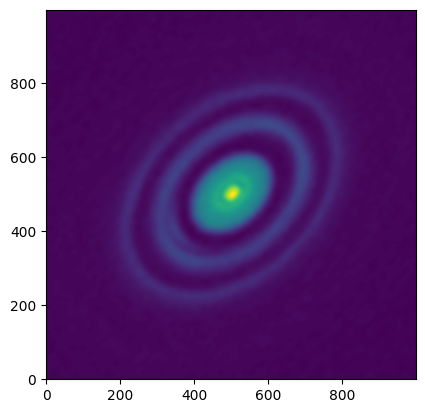

In [ ]:
plt.imshow(image, origin='lower')

In [ ]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(labels[i], mcmc[1], q[0], q[1])

xcen 1.424899761433878 0.07404220899030922 0.06952376085393541
ycen 1.4654931299090255 0.0691230350197456 0.07338112589288293
ring_r0 67.40833509500096 0.06611904735521534 0.07309685525825671
ring_tau 0.3701057572832157 0.008009723655640788 0.008413490809809077
ring_w 4.500308854824332 0.11552035423898577 0.1249489515996185
ring_h 3.7431220290713174 0.19701652707093276 0.20325375871573392


In [ ]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    print(labels[i], mcmc)

xcen [1.35085755 1.42489976 1.49442352]
ycen [1.39637009 1.46549313 1.53887426]
ring_r0 [67.34221605 67.4083351  67.48143195]
ring_tau [0.36209603 0.37010576 0.37851925]
ring_w [4.3847885  4.50030885 4.62525781]
ring_h [3.5461055  3.74312203 3.94637579]


In [62]:
ring_r0, ring_tau, ring_w, ring_h = 67.7554665975438, 0.7511038609565008, 4.562632473038108, 4.18722700247981

x1, x2 = 0.9420525547875308, 1.1911604647674632
xx_data_point_cen = xx_data_point + x1
yy_data_point_cen = yy_data_point + x2
obs_data_points = fit_ring.interpolate_data(x_obs, y_obs, image.T, xx_data_point_cen, yy_data_point_cen)

intensity = fit_ring.raytrace_ring(ring_r0, ring_tau, ring_w, ring_h, incl, posang, temperature_t0, temperature_r0, temperature_pow, wavelength, xx_model_incl, yy_model_incl)
#intensity_conv = fit_ring.convolution(intensity, beam_kernel)
intensity_conv = signal.fftconvolve(intensity, beam_kernel, mode="same")
model_data_points = fit_ring.interpolate_data(x_model, y_model, intensity_conv.T, xx_data_point, yy_data_point)
obs_data_points = fit_ring.interpolate_data(x_obs, y_obs, image.T, xx_data_point, yy_data_point)

(-67.34146645398451, 67.34146645398451, -67.34146645398451, 67.34146645398451)

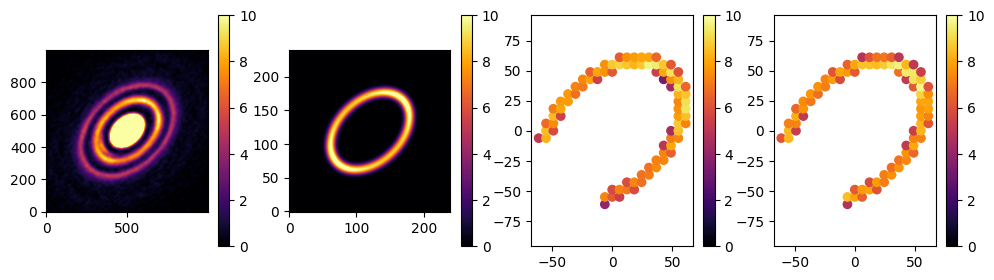

In [63]:

# with colorbar
fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(141)
im1 = ax1.imshow(image, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im1, ax=ax1)
ax2 = fig.add_subplot(142)
im2 = ax2.imshow(intensity, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im2, ax=ax2)
ax3 = fig.add_subplot(143)
im3 = ax3.scatter(xx_data_point, yy_data_point, c=obs_data_points, cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im3, ax=ax3)
ax3.axis('equal')
ax4 = fig.add_subplot(144)
im4 = ax4.scatter(xx_data_point, yy_data_point, c=model_data_points, cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im4, ax=ax4)
ax4.axis('equal')

(-67.34146645398451, 67.34146645398451, -67.34146645398451, 67.34146645398451)

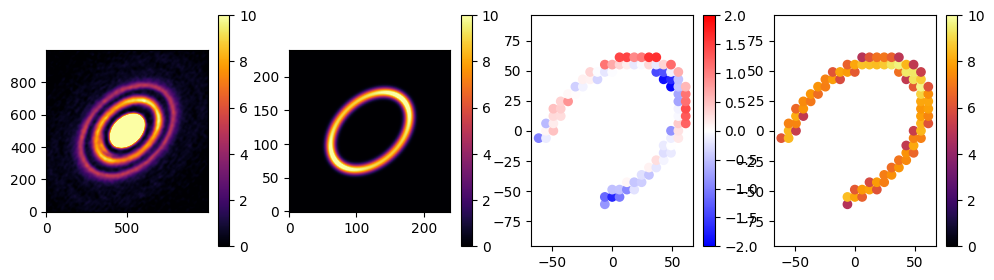

In [64]:
fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(141)
im1 = ax1.imshow(image, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im1, ax=ax1)
ax2 = fig.add_subplot(142)
im2 = ax2.imshow(intensity, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im2, ax=ax2)
ax3 = fig.add_subplot(143)

# blue to red
im3 = ax3.scatter(xx_data_point, yy_data_point, c=obs_data_points-model_data_points, cmap="bwr", vmin = -2, vmax = 2)
fig.colorbar(im3, ax=ax3)
ax3.axis('equal')
ax4 = fig.add_subplot(144)
im4 = ax4.scatter(xx_data_point, yy_data_point, c=model_data_points, cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im4, ax=ax4)
ax4.axis('equal')

(-67.34146645398451, 67.34146645398451, -67.34146645398451, 67.34146645398451)

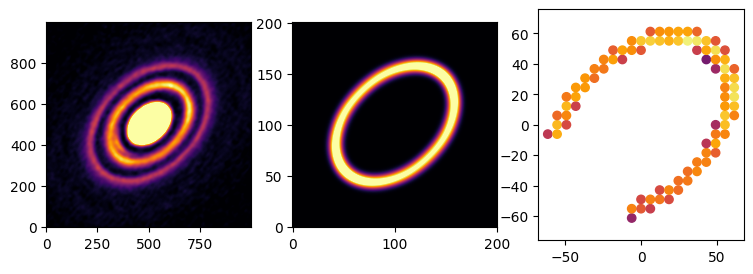

In [ ]:
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_subplot(131)
ax1.imshow(image, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
ax2 = fig.add_subplot(132)
ax2.imshow(intensity, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
ax3 = fig.add_subplot(133)
ax3.scatter(xx_data_point, yy_data_point, c=obs_data_points, cmap="inferno", vmin = 0, vmax = 10)
ax3.axis('equal')

In [ ]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

8 CPUs


(1000, 1000)